In [0]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

In [2]:
batch_size =64

train_dataset = datasets.MNIST(root='./MNIST/',
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='./MNIST/',
                              train=False,
                              download=True,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27374927.33it/s]                            


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 450907.80it/s]
  1%|          | 16384/1648877 [00:00<00:11, 143508.20it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7470336.41it/s]                           
8192it [00:00, 181446.19it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
print(train_loader.dataset.data.shape)
print(train_loader.dataset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [0]:
class Generator(nn.Module):  
    def __init__(self):
        super(Generator, self).__init__()
        self.lin1 = nn.Linear(4, 100)
        self.lin2 = nn.Linear(100, 400)
        self.lin3 = nn.Linear(400, 784)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.leaky_relu(x,0.2)
        x = self.lin2(x)
        x = F.leaky_relu(x,0.2)
        x = self.lin3(x)
        return torch.tanh(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.lin1 = nn.Linear(784,256)
        self.lin2 = nn.Linear(256,256)
        self.lin3 = nn.Linear(256,1)

    
    def forward(self,x):
        x = F.leaky_relu(self.lin1(x),0.2)
        
        x = F.leaky_relu(self.lin2(x),0.2)
        
        x = F.leaky_relu(self.lin3(x),0.2)
        
        return torch.sigmoid(x)
        

In [0]:
def generate_(batch_size):
  return torch.from_numpy(np.random.multivariate_normal(mean=[0,0,0,0],cov =np.identity(4),size=batch_size)).type(torch.float)

In [0]:
D = Discriminator()
G = Generator()

# Binary cross entropy loss and optimizer

criterion = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [0]:
# Function to show an image
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
  plt.axis('off')
  plt.show()

torch.Size([64, 1, 28, 28])
torch.Size([64])


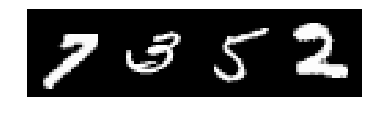

In [15]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[:4],nrow=4))

In [16]:
# Start training
total_step = len(train_loader)
diss_loss =[]
gen_loss =[]
accuracy = []
num_epochs = 50

for epoch in range(num_epochs):
    diss =0
    gen =0
    train_correct =0
    for i ,(images,target) in enumerate(train_loader):
        

        batch_size = images.size(0)

        images = images.view(batch_size, -1)
        images = Variable(images,requires_grad =False)

        # Create the labels
        real_labels = torch.ones(batch_size, 1)
        real_labels = Variable(real_labels)
        fake_labels = torch.zeros(batch_size, 1)
        fake_labels = Variable(fake_labels)
        
        
        # set grad to zero
        d_optimizer.zero_grad()
        
        g_optimizer.zero_grad()
        
        
        ## Training Discriminator
        
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        
        z = generate_(batch_size)
        z = Variable(z)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        
        d_loss = d_loss_real + d_loss_fake
        
        d_loss.backward()
        d_optimizer.step()
        
        diss+=d_loss.item()
        
        
        ## Train Generator
        z = generate_(batch_size)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        gen+=g_loss.item()
        
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Generator_loss: {:.4f}, Discriminator_loss: {:.4f}' 
                      .format(epoch, num_epochs, i+1, total_step, g_loss.item(),d_loss.item()))
      
    diss_loss.append(diss)
    gen_loss.append(gen)

Epoch [0/50], Step [200/938], Generator_loss: 0.7924, Discriminator_loss: 0.6290
Epoch [0/50], Step [400/938], Generator_loss: 1.2217, Discriminator_loss: 0.8508
Epoch [0/50], Step [600/938], Generator_loss: 1.4404, Discriminator_loss: 0.9789
Epoch [0/50], Step [800/938], Generator_loss: 1.0578, Discriminator_loss: 0.7767
Epoch [1/50], Step [200/938], Generator_loss: 0.8713, Discriminator_loss: 1.1091
Epoch [1/50], Step [400/938], Generator_loss: 0.9157, Discriminator_loss: 0.9222
Epoch [1/50], Step [600/938], Generator_loss: 0.7828, Discriminator_loss: 0.8391
Epoch [1/50], Step [800/938], Generator_loss: 0.9165, Discriminator_loss: 0.7169
Epoch [2/50], Step [200/938], Generator_loss: 0.7755, Discriminator_loss: 0.8247
Epoch [2/50], Step [400/938], Generator_loss: 2.5823, Discriminator_loss: 1.7073
Epoch [2/50], Step [600/938], Generator_loss: 1.4875, Discriminator_loss: 0.7375
Epoch [2/50], Step [800/938], Generator_loss: 1.3231, Discriminator_loss: 0.9267
Epoch [3/50], Step [200/938]

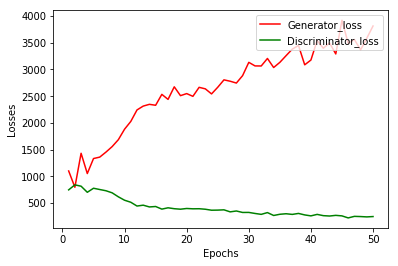

In [17]:
fig2 = plt.figure(1)        
plt.plot(range(1, num_epochs+1),gen_loss,'r-',label='Generator_loss')        
plt.plot(range(1, num_epochs+1),diss_loss,'g-',label='Discriminator_loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

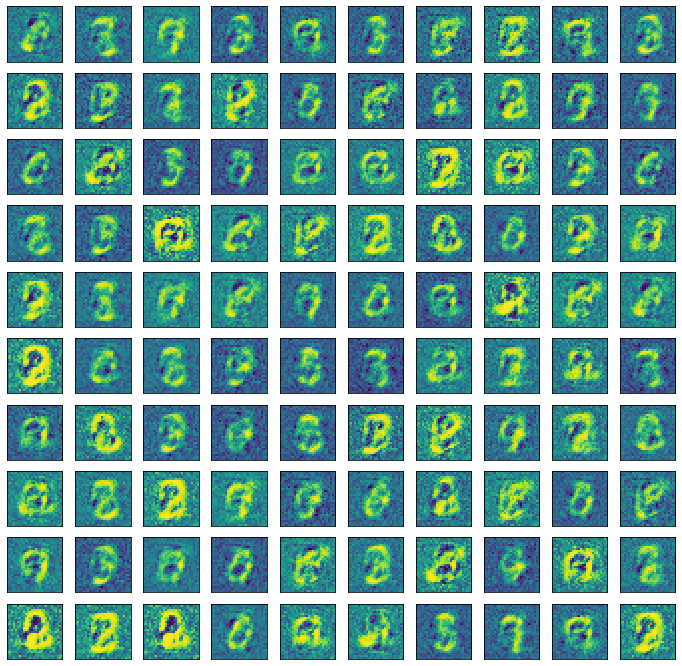

In [18]:
G.eval()
z = generate_(100)
generated_images = Variable(G(z),requires_grad =False)
z= generated_images.reshape((100,28,28))
z=z.cpu().detach().numpy()
fig=plt.figure(figsize=(12, 12))

columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = z[i-1]
    fig.add_subplot(rows, columns,i)
    
    show = plt.imshow(img)
    show.axes.get_xaxis().set_visible(False)
    show.axes.get_yaxis().set_visible(False)
plt.savefig('result.jpg')
plt.show()